In [ ]:
import os, glob, pickle
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, RocCurveDisplay

import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"]='2,3'
mirrored_strategy = tf.distribute.MirroredStrategy()

In [ ]:
def loads_npy_with_y(base_path, ids, y_value):
    loaded_npa_list = []
    for id in ids:
        file_path = glob.glob(f'{base_path}/{id}*.npy')[0]
        if not isinstance(file_path, str):
            raise Exception(f"could'n find id({id}) file ")
        npa = np.load(file_path)
        n = npa.shape[0]
        y = np.array([y_value] * n, dtype=npa.dtype)
        npa = np.concatenate([npa,y.reshape(-1,1)], axis=1)
        loaded_npa_list.append(npa)
    
    return np.concatenate(loaded_npa_list, axis=0)

In [5]:
train_ci_ids = ["HM0001", "HM0002", "HS0003", "HS0004", "HS0005", "HS0006", "HS0011"]
test_ci_ids = ["HM0004", "HM0005", "HS0001", "HS0002", "HS0009", "HS0010", "HS0012","HS0013"]

train_hi_ids = ["HL0052", "HL0074", "HL0028", "HL0150", "HL0039", "HL0019", "HL0029"]
test_hi_ids = ["HL0005", "HL0075", "HL0024", "HL0034", "HL0089"]

# test_ci_with_y = loads_npy_with_y("CI",train_ci_ids,1)
test_ci_with_y = loads_npy_with_y("CI",test_ci_ids,1)

# test_hi_with_y = loads_npy_with_y("HI",train_hi_ids,0
test_hi_with_y = loads_npy_with_y("HI",test_hi_ids,0)

test_X_with_Y = np.concatenate([test_ci_with_y, test_hi_with_y], axis=0)
np.random.shuffle(test_X_with_Y)

test_X = test_X_with_Y[:,:-1]
test_Y = test_X_with_Y[:, -1]

In [6]:

model = tf.keras.models.load_model('model1_E10_B10_T53300_V17700_val-acc0.824.h5')
print(test_X.shape)


(43694, 64000)


In [7]:
## it's too big to use the whole data

# pred_40000 = []
pred_40000 = np.array([],dtype=test_Y.dtype)
for i in range(0,40):
    start_num = i*1000
    end_num = start_num + 1000
    t_x = test_X[start_num:end_num]
    
#     pred = model.predict(t_x[:,:,np.newaxis])
    pred = model.predict(t_x)
#     pred = (pred>0.5).astype(test_Y.dtype)
    pred = np.where(pred>0.5, 1, 0)
#     pred_40000.append(pred)
#     pred_40000 += list(pred)
    pred_40000 = np.append(pred_40000, pred)
    
    
pred_40000 = np.array(pred_40000, dtype=test_Y.dtype)
print("pred_40000.shape: ", pred_40000.shape)

pred_40000.shape:  (41000,)


In [8]:
tn, fp, fn, tp = confusion_matrix(test_Y[:40000], pred_40000).ravel()

accuracy = (tn + tp) / (tn+tp+fn+fp)
recall = tp / (tp+fn)
precision = tp / (fp+tp)
f1_score = 2*(recall*precision) / (recall + precision)
specificity = tn / (fp+tn)


print("accuracy: ", accuracy)
print("recall: ", recall)
print("precision: ", precision)
print("f1_score: ", f1_score)
print("specificity: ",specificity)

RocCurveDisplay.from_predictions(test_Y[:40000], pred_40000)
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [40000, 41000]

In [71]:
train_ci_ids = ["HM0001", "HM0002", "HS0003", "HS0004", "HS0005", "HS0006", "HS0011"]
test_ci_ids = ["HM0004", "HM0005", "HS0001", "HS0002", "HS0009", "HS0010", "HS0012","HS0013"]

train_hi_ids = ["HL0052", "HL0074", "HL0028", "HL0150", "HL0039", "HL0019", "HL0029"]
test_hi_ids = ["HL0005", "HL0075", "HL0024", "HL0034", "HL0089"]

# test_ci_with_y = loads_npy_with_y("CI",train_ci_ids,1)
test_ci_with_y = loads_npy_with_y("CI",test_ci_ids,1)

# test_hi_with_y = loads_npy_with_y("HI",train_hi_ids,0)
test_hi_with_y = loads_npy_with_y("HI",test_hi_ids,0)

test_X_with_Y = np.concatenate([test_ci_with_y, test_hi_with_y], axis=0)
np.random.shuffle(test_X_with_Y)

test_X = test_X_with_Y[:,:-1]
test_Y = test_X_with_Y[:, -1]

In [72]:
print(np.unique(test_Y))

[0. 1.]


In [73]:
# ## it's too big to use the whole data

# # pred_40000 = []
# accs = []
# recalls = []
# precisions = []
# f1_scores = []
# specificities = []
# pred_40000 = np.array([],dtype=np.int64)
# for i in range(1,40):
#     start_num = i*1000
#     end_num = start_num + 1000
#     t_x = test_X[start_num:end_num]
#     t_y = test_Y[start_num:end_num]
# #     pred = model.predict(t_x[:,:,np.newaxis])
#     pred = model.predict(t_x)
# #     print("pred shape: ", pred.shape)
# #     pred = (pred>0.5).astype(test_Y.dtype)
#     pred = np.where(pred>0.5, 1, 0)
# #     print("t_y shape: ", t_y.shape)
# #     print("pred where shape: ", pred.shape)
# #     pred = pred.flatten()
# #     n = 40
# #     print(f'pred {n}:')
# #     print(pred[:n])
# #     print(f't_y {n}:')
# #     print(t_y[:n])
# #     print("pred flatten shape: ", pred.shape)
#     pred_40000 = np.append(pred_40000, pred)
# # #     pred_40000.append(pred)
# #     pred_40000 += list(pred)

# #     tn, fp, fn, tp = confusion_matrix(t_y, pred).ravel()

# #     accuracy = (tn + tp) / (tn+tp+fn+fp)
# #     recall = tp / (tp+fn)
# #     precision = tp / (fp+tp)
# #     f1_score = 2*(recall*precision) / (recall + precision)
# #     specificity = tn / (fp+tn)

# #     print("start_num: ",start_num)
# #     print("accuracy: ", accuracy)
# #     print("recall: ", recall)
# #     print("precision: ", precision)
# #     print("f1_score: ", f1_score)
# #     print("specificity: ",specificity)

# #     accs.append(accuracy)
# #     recalls.append(recall)
# #     precisions.append(precision)
# #     f1_scores.append(f1_score)
# #     specificities.append(specificity)
    


    

pred shape:  (1000, 1)
t_y shape:  (1000,)
pred where shape:  (1000, 1)
pred 40:
[0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0
 0 0 1]
t_y 40:
[0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1.]
pred flatten shape:  (1000,)
start_num:  0
accuracy:  0.997
recall:  0.9894366197183099
precision:  1.0
f1_score:  0.9946902654867256
specificity:  1.0
test_Y
[0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 1
 0 0 1]
float32
pred
[0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0
 0 0 1]
int64
pred_40000
[0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0
 0 0 1]
int64
start_num2:  0
accuracy2:  0.997
recall2:  0.9894366197183099
precision2:  1.0
f1_score2:  0.9946902654867256
specificity2:  1.0
pred shape:  (1000, 1)
t_y shape:  (1000,)
pred where shape:  (1000, 1)
pred 40:
[0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 1 1 0 0 

pred shape:  (1000, 1)
t_y shape:  (1000,)
pred where shape:  (1000, 1)
pred 40:
[0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0
 0 0 0]
t_y 40:
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
pred flatten shape:  (1000,)
start_num:  9000
accuracy:  0.999
recall:  0.9966666666666667
precision:  1.0
f1_score:  0.9983305509181971
specificity:  1.0
test_Y
[0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 1
 0 0 1]
float32
pred
[0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0
 0 0 0]
int64
pred_40000
[0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0
 0 0 1]
int64
start_num2:  9000
accuracy2:  0.9944
recall2:  0.9814555633310007
precision2:  0.9989316239316239
f1_score2:  0.9901164842922697
specificity2:  0.9995799495939512
pred shape:  (1000, 1)
t_y shape:  (1000,)
pred where shape:  (1000, 1)
pred 40:
[1 0 1 0 1 0 0

pred shape:  (1000, 1)
t_y shape:  (1000,)
pred where shape:  (1000, 1)
pred 40:
[1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0
 0 1 1]
t_y 40:
[1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.]
pred flatten shape:  (1000,)
start_num:  18000
accuracy:  0.992
recall:  0.9737704918032787
precision:  1.0
f1_score:  0.9867109634551495
specificity:  1.0
test_Y
[0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 1
 0 0 1]
float32
pred
[1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0
 0 1 1]
int64
pred_40000
[0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0
 0 0 1]
int64
start_num2:  18000
accuracy2:  0.9936842105263158
recall2:  0.9785557184750733
precision2:  0.9994384125795582
f1_score2:  0.9888868308946102
specificity2:  0.9997784997046663
pred shape:  (1000, 1)
t_y shape:  (1000,)
pred where shape:  (1000, 1)
pred 40:


pred shape:  (1000, 1)
t_y shape:  (1000,)
pred where shape:  (1000, 1)
pred 40:
[0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 1
 0 0 0]
t_y 40:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0.
 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
pred flatten shape:  (1000,)
start_num:  27000
accuracy:  0.993
recall:  0.9762845849802372
precision:  0.9959677419354839
f1_score:  0.9860279441117764
specificity:  0.998661311914324
test_Y
[0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 1
 0 0 1]
float32
pred
[0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 1
 0 0 0]
int64
pred_40000
[0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0
 0 0 1]
int64
start_num2:  27000
accuracy2:  0.9935714285714285
recall2:  0.9787654320987654
precision2:  0.998991935483871
f1_score2:  0.9887752556747319
specificity2:  0.9995979899497487
pred shape:  (1000, 1)
t_y shape:  (1000,)
pred where

pred shape:  (1000, 1)
t_y shape:  (1000,)
pred where shape:  (1000, 1)
pred 40:
[1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 0 0 1 1 1 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 0 1
 0 1 0]
t_y 40:
[1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0.
 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
pred flatten shape:  (1000,)
start_num:  36000
accuracy:  0.995
recall:  0.9824561403508771
precision:  1.0
f1_score:  0.9911504424778761
specificity:  1.0
test_Y
[0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 1
 0 0 1]
float32
pred
[1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 0 0 1 1 1 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 0 1
 0 1 0]
int64
pred_40000
[0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0
 0 0 1]
int64
start_num2:  36000
accuracy2:  0.9936756756756757
recall2:  0.9791725302561216
precision2:  0.9988515647430376
f1_score2:  0.988914155770324
specificity2:  0.9995444364299002
pred shape:  (1000, 1)
t_y shape:  (1000,)
pred where shape:  (1000, 1)
pred 40:
[

In [74]:
# pred_40000 = np.array(pred_40000, dtype=test_Y.dtype)
print("pred_40000.shape: ", pred_40000.shape)

print("averages")
print("accs: ", np.mean(accs))
print("recalls: ", np.mean(recalls))
print("precisions: ", np.mean(precisions))
print("f1_scores: ", np.mean(f1_scores))
print("specificities: ", np.mean(specificities))


pred_40000.shape:  (40000,)
averages
accs:  0.9935500000000002
recalls:  0.9787037574055368
precisions:  0.9989279854839035
f1_scores:  0.9886955946060851
specificities:  0.9995809153134487


test_Y_40000.shape:  (40000,)
dtypes test_Y :  float32 pred_40000:  int64
accuracy:  0.99355
recall:  0.9787123572170301
precision:  0.9989401165871754
f1_score:  0.9887227904537109
specificity:  0.9995781184081002


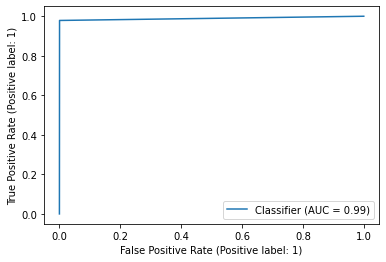

In [75]:
test_Y_40000 = test_Y[0:40000]
print("test_Y_40000.shape: ", test_Y_40000.shape)
print("dtypes test_Y : ",test_Y.dtype, "pred_40000: ", pred_40000.dtype)
tn, fp, fn, tp = confusion_matrix(test_Y_40000, pred_40000).ravel()

accuracy = (tn + tp) / (tn+tp+fn+fp)
recall = tp / (tp+fn)
precision = tp / (fp+tp)
f1_score = 2*(recall*precision) / (recall + precision)
specificity = tn / (fp+tn)


print("accuracy: ", accuracy)
print("recall: ", recall)
print("precision: ", precision)
print("f1_score: ", f1_score)
print("specificity: ",specificity)

RocCurveDisplay.from_predictions(test_Y[:40000], pred_40000)
plt.show()